In [1]:
import numpy as np
import torch
from torchvision import transforms, models, datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
class croptop(object):
    def __init__(self, amt) -> None:
        self.amt = amt
    def __call__(self, img):
        img = transforms.functional.crop(img, top = self.amt,left=0,width = img.shape[2],height =img.shape[1]-200)
        return img

In [4]:

# root = "./../images/snowmodelimages"
# transformation = transforms.Compose([transforms.ToTensor(),croptop(200),transforms.Resize((224,224))
                                     
#                                     ])
# data = datasets.ImageFolder(root = root, transform=transformation)

# csvloader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle = True)
# snow, nosnow = [], []
# # for img, lbl in csvloader:
# #     if(lbl == 1):
# #         snow.append(img)
    
# # snow = torch.cat(snow, dim = 0)

# # train_snow, test_snow = torch.split(snow, [int(0.8*len(snow)), len(snow) - int(0.8*len(snow))])
# # print('data loaded')

# # torch.save(train_snow, './snowdatatensors/train_snow.pt')

# # torch.save(test_snow, './snowdatatensors/test_snow.pt')

# for img, lbl in csvloader:
#     if(lbl == 0):
#         nosnow.append(img)
# nosnow = torch.cat(nosnow, dim = 0)

# train_nosnow, test_nosnow = torch.split(nosnow, [int(0.8*len(nosnow)), len(nosnow) - int(0.8*len(nosnow))])
# print('data loaded')


# torch.save(train_nosnow, './snowdatatensors/train_nosnow.pt')

# torch.save(test_nosnow, './snowdatatensors/test_nosnow.pt')




In [5]:



class TryRandomSolarize(object):
    def __init__(self, threshold, p) -> None:
        self.solarize = transforms.RandomSolarize(threshold,p)
    def __call__(self,sample):
        try:
            
            img = self.solarize(img)
        except:
            img = sample
        return sample


In [6]:
transformation = transforms.Compose([TryRandomSolarize(100.0,0.5),transforms.RandomPerspective(0.6, p=0.5),transforms.GaussianBlur(5)])

class riverdataset(torch.utils.data.Dataset):
    def __init__(self, snow_file, nosnow_file, transform = None):
        """
        Arguments:
            snow_file (string): Path to the .pt file
            nosnow_file (string): Path to the .pt file
            noise (boolean): add guassian noise
        """
        snow = torch.load(snow_file)
        nosnow = torch.load(nosnow_file)
        labels1 = torch.tensor([1 for i in range(len(snow))])
        labels0 = torch.tensor([0 for i in range(len(nosnow))])
        self.data = torch.cat([snow, nosnow], dim= 0)
        self.labels = torch.cat([labels1, labels0], dim = 0)
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        if(self.transform):
            image = self.transform(image)
        return image, self.labels[idx]
    

train_set = riverdataset("./snowdatatensors/train_snow.pt", "./snowdatatensors/train_nosnow.pt", transformation)
test_set = riverdataset('./snowdatatensors/test_snow.pt', "./snowdatatensors/test_nosnow.pt", False)


In [7]:
#Create additional layers for snow classification
modeltype = 'resnet50'

if modeltype == 'resnet50':
    model = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V2)
    for param in model.parameters():
        param.requires_grad = False   

    model.fc = torch.nn.Sequential(
        torch.nn.Linear(2048, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,2),
        torch.nn.Softmax(dim= 1)
    )
    params = model.fc.parameters()
elif modeltype == 'VGG':
    model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False   

    classifier = torch.nn.Sequential(
        torch.nn.Linear(4096, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,2),
        torch.nn.Softmax(dim= 1)
    )
    model.classifier[-1] = classifier
    params = model.classifier[-1].parameters()


model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
#parameters

lr = 0.0001
batch_size = 128
epochs =40
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params, lr)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 1, shuffle= False)

In [9]:
def calc_test_accuracy(model, dataloader,epoch, save_pic = False, criterion =torch.nn.CrossEntropyLoss()):
      model.eval()
      TP = 0
      FP = 0
      TN = 0
      FN = 0
      val_loss = 0
      with torch.no_grad():
            for num, (i, l) in enumerate(dataloader):
                  if(save_pic):     
                        plt.imsave(f"image{num}.png",i.squeeze(0).permute(1,2,0).numpy() )
                 
                  if(l == torch.tensor([0])):
                        l = torch.tensor([1, 0])
                  else:
                        l = torch.tensor([0, 1])
                  l = l.reshape([1,2])
                  i,l = i.to(device), l.to(device).float()
                  t_out = model(i)
                  
                  
                  val_loss+= criterion(t_out, l).item()
                  predicted = np.argmax(t_out.cpu().numpy(), axis = 1)
                  true_label = np.argmax(l.cpu().numpy(), axis =1)
                 
                  if(predicted == 1 and true_label == 1):
                        TP +=1
                  elif(predicted == 0 and true_label == 0):
                        TN +=1
                  if(predicted == 1 and true_label == 0):
                        FP +=1
                        #plt.imsave(f"imageFP{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
                  elif(predicted == 0 and true_label == 1):
                        FN +=1
                        #plt.imsave(f"imageFN{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
            try:
                  precision = TP/(TP + FP)
            except:
                  precision = 0
            try:
                  recall = TP/(TP + FN)
            except:
                  recall = 0
            stats = dict(
                  epoch = epoch,
                  accuracy = (TN+TP) /(TP+TN+FP+FN),
                  precision = precision,
                  recall = recall,
                  loss = val_loss/(TP+FP+TN+FN)
            
            )
            print(f'True positives: {TP}')
            print(f'True negatives: {TN}')
            print(f'False positives: {FP}')
            
            print(f'False negatives: {FN}')
            return stats


In [10]:

#training loop
running_loss = 0 
train_loss, test_loss = [],[]
# model = torch.load("model.pth")
model.train()
verbose = 10
steps = 0

for epoch in range(0, epochs):
    print(epoch)
    for images,labels in train_loader:
        steps +=1
        labels = torch.nn.functional.one_hot(labels)
        images,labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        out = model(images)
        
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    val_loss = 0
    num_correct = 0
    model.eval()
    train_loss.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        stats = calc_test_accuracy(model, test_loader, epoch+1)
        
        test_loss.append(stats["loss"])
        stats["training_loss"] = train_loss
        torch.save(stats, f"stats-{epoch+1}.pt")
        print(stats)
    running_loss= 0
    model.train()
    torch.save(model, 'model.pth')
    
  


        
    

0
True positives: 407
True negatives: 35
False positives: 271
False negatives: 1
{'epoch': 1, 'accuracy': 0.6190476190476191, 'precision': 0.6002949852507374, 'recall': 0.9975490196078431, 'loss': 0.6276908320706097, 'training_loss': [0.6552950454794843]}
1
True positives: 391
True negatives: 242
False positives: 64
False negatives: 17
{'epoch': 2, 'accuracy': 0.8865546218487395, 'precision': 0.8593406593406593, 'recall': 0.9583333333333334, 'loss': 0.5598971439259393, 'training_loss': [0.6552950454794843, 0.5816497802734375]}
2
True positives: 384
True negatives: 266
False positives: 40
False negatives: 24
{'epoch': 3, 'accuracy': 0.9103641456582633, 'precision': 0.9056603773584906, 'recall': 0.9411764705882353, 'loss': 0.5069287488190066, 'training_loss': [0.6552950454794843, 0.5816497802734375, 0.5158324137977932]}
3
True positives: 366
True negatives: 282
False positives: 24
False negatives: 42
{'epoch': 4, 'accuracy': 0.907563025210084, 'precision': 0.9384615384615385, 'recall': 0

In [11]:
model = torch.load('model.pth')
stats = calc_test_accuracy(model, test_loader, epoch+1)
stats["training_loss"] = train_loss
torch.save(stats, f"stats-{epoch+1}.pt")
print(stats)



True positives: 399
True negatives: 301
False positives: 5
False negatives: 9
{'epoch': 40, 'accuracy': 0.9803921568627451, 'precision': 0.9876237623762376, 'recall': 0.9779411764705882, 'loss': 0.344771977941863, 'training_loss': [0.6552950454794843, 0.5816497802734375, 0.5158324137977932, 0.48068358716757403, 0.4531124324902244, 0.4382182346737903, 0.4280448141305343, 0.42154281294864154, 0.4101420563200246, 0.40403916783954785, 0.4008281891760619, 0.3983405867348547, 0.391984057167302, 0.3872421137664629, 0.3866601184658382, 0.3789477711138518, 0.3785866149093794, 0.37655601164569025, 0.3719237083974092, 0.3724991692149121, 0.373047367386196, 0.37329176586607227, 0.3696977729382722, 0.36388780500577844, 0.3654570890509564, 0.36556592972382257, 0.3611084002515544, 0.3634529593198196, 0.3599701614483543, 0.3636434350324714, 0.36087212484815845, 0.3628891278868136, 0.3539220587066982, 0.35448355778403906, 0.36207859412483545, 0.35717967930047406, 0.3516646338545758, 0.3552554236805957,

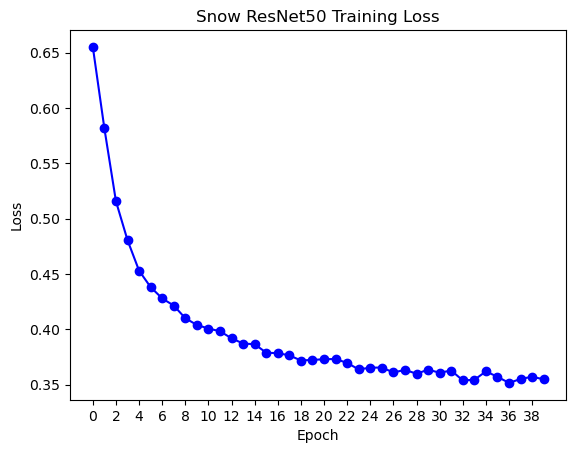

In [12]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(train_loss, marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow ResNet50 Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.xticks([i for i in range(0,40,2)])

# Display the plot
plt.show()

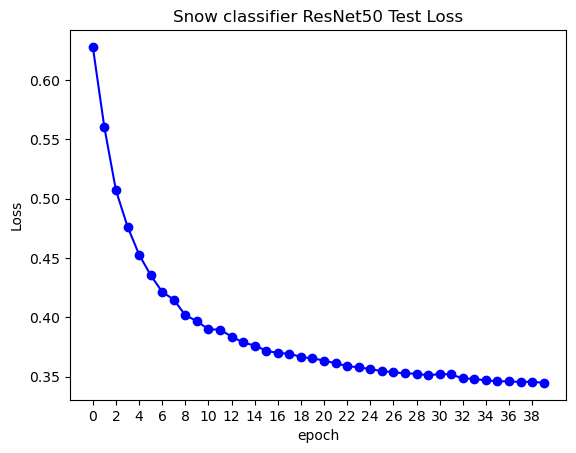

In [13]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(test_loss,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow classifier ResNet50 Test Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
plt.xticks([i for i in range(0,40,2)])

# Display the plot
plt.show()

[0.6190476190476191, 0.8865546218487395, 0.9103641456582633, 0.907563025210084, 0.9243697478991597, 0.938375350140056, 0.9453781512605042, 0.938375350140056, 0.9537815126050421, 0.957983193277311, 0.9663865546218487, 0.9607843137254902, 0.9649859943977591, 0.9719887955182073, 0.9677871148459384, 0.9677871148459384, 0.9705882352941176, 0.9677871148459384, 0.9705882352941176, 0.9719887955182073, 0.9677871148459384, 0.9705882352941176, 0.9677871148459384, 0.969187675070028, 0.9747899159663865, 0.9677871148459384, 0.9761904761904762, 0.9747899159663865, 0.9747899159663865, 0.9761904761904762, 0.9733893557422969, 0.9789915966386554, 0.9775910364145658, 0.9761904761904762, 0.9775910364145658, 0.9803921568627451, 0.9803921568627451, 0.9789915966386554, 0.9747899159663865, 0.9803921568627451]


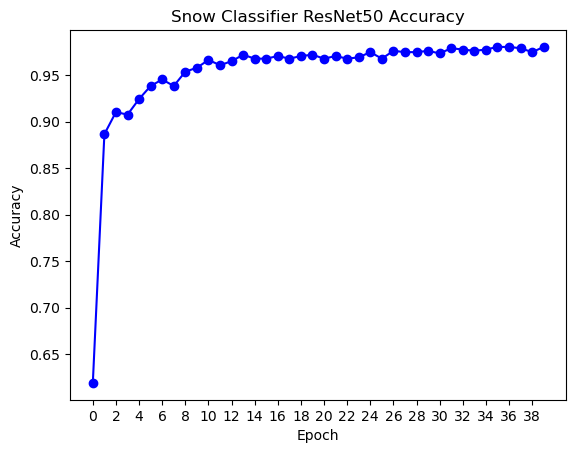

In [14]:
accuracies = []
fig, ax = plt.subplots()
for i in range(1,41):
    accuracies.append(torch.load(f'stats-{i}.pt')['accuracy'])
# Plot the data
print(accuracies)
ax.plot(accuracies,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow Classifier ResNet50 Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.xticks([i for i in range(0,40,2)])

# Display the plot
plt.show()



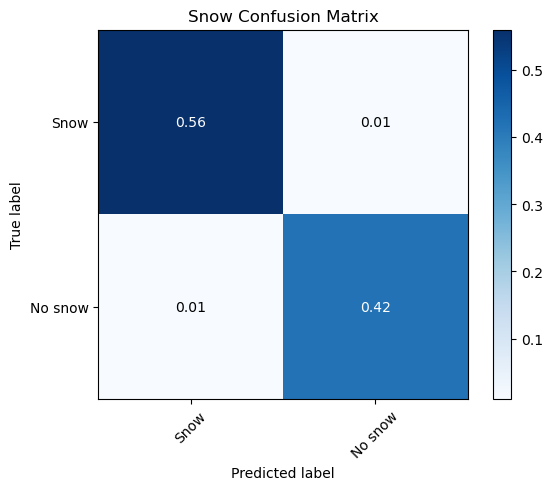

In [1]:

import matplotlib.pyplot as plt
import numpy as np

# Example confusion matrix (replace this with your actual confusion matrix)
confusion_matrix = np.array([ [0.56, 0.01],[0.01, 0.42]])

# Define class labels (replace these with your class labels if you have them)
class_labels = ['Snow', 'No snow']

# Create a heatmap for the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Set tick marks and labels for the plot
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)

# Add annotations to each cell in the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        color = 'black' if i != j else 'white'  
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color=color)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Snow Confusion Matrix')
plt.show()
